# Coloração de grafos

O problema da *coloração de grafos* (https://en.wikipedia.org/wiki/Graph_coloring) consiste em descobrir uma atribuição de cores aos vértices, de tal forma que vértices adjacentes não tenham a mesma cor.
Este problema pode ser formulado como um problema de decisão: dado um grafo e um número não negativo $K$ determinar se é possível colorir o grafo com no máximo $K$ cores, devolvendo uma coloração válida se tal for possível.

Em Python podemos usar um dicionário para representar o grafo por *lista de adjacência*.
Por exemplo, o dicionário `adj` representa um grafo *não orientado* e *não pesado* com 6 vértices e 7 arcos.


In [2]:
adj = {0:[1,4],1:[0,2,4],2:[1,3],3:[2,4,5],4:[0,1,3],5:[3]}

É possível usar um SAT solver para resolver o problema de colorir um grafo $(V,E)$ com $K$ cores. Para tal, vamos necessitar de $|V| \times K$ variáveis proposicionais, onde a variável $x_{i,j}$ determina se o vértice $i$ tem cor $j$.

O conjunto de restrições é o seguinte:

  * Para cada arco $(u,v)$ as cores de $u$ e $v$ têm que ser diferentes.
  
  $$
  \ \ \ \ \ \ \mbox{para cada }   1\leq j \leq K, \qquad ( x_{uj} \to \neg x_{vj})
  $$
  * Cada vértice tem pelo menos uma cor.
  $$
   \mbox{para cada } 1\leq i \leq |V|, \qquad  \bigvee_{j=1}^{K}  x_{ij}
  $$
  * Cada vértice tem no máximo uma cor.
  $$
  \ \ \ \ \ \ \ \  \mbox{para cada } 1\leq i \leq |V|, \qquad \bigwedge_{a=1}^{K-1}\bigwedge_{b=a+1}^{K}
  (\neg x_{ia} \vee \neg x_{ib})
  $$

Começamos por instalar a biblioteca PySAT (https://pysathq.github.io/index.html).

In [1]:
!pip install python-sat[pblib,aiger]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.0 MB/s eta 0:00:00
  Created wheel for pypblib: filename=pypblib-0.0.4-cp310-cp310-linux_x86_64.whl size=2973389 sha256=803650ef792c4dba581f16ab0ad64b814ebc1b10262fb769436c3c3ed9b45547
  Stored in directory: /root/.cache/pip/wheels/a8/3d/9c/b980a09d6084eaeb9b336edbe20371c53c2550226daeee2025
Successfully built pypblib


A função `coloring` recebe a lista de adjacência, o número de vértices e o número de cores com que se pode colorir o grafo. A função imprime uma coloração para o grafo, se isso for possível.

Note que começamos por criar um dicionário, x, de forma a fazer o mapeamento entre cada variável proposicional $x_{i,j}$ e o valor inteiro que lhe corresponde no formato DIMACS CNF.

In [3]:
from pysat.solvers import Minisat22


def coloring(graph,V,K):

    s = Minisat22()

    # mapeamento x_ij para variáveis DIMACS
    c = 1
    x = {}
    for i in range(V):
        x[i] = {}
        for j in range(K):
            x[i][j] = c
            c += 1

    # Para cada arco (u,v) as cores de u e v têm que ser diferentes.
    for j in range(K):
        for u in graph:
            for v in graph[u]:
                s.add_clause([-x[u][j] , -x[v][j]])

    # Cada vértice tem pelo menos uma cor.
    for i in range(V):
        s.add_clause([x[i][j] for j in range(K)])

    # Cada vértice tem no máximo uma cor.
    for i in range(V):
        for a in range(K-1):
            for b in range(a+1,K):
                s.add_clause([-x[i][a] , -x[i][b]])

    if s.solve():
        m = s.get_model()
        print("Modelo: ",m)

        for v in range(V):
            for k in range(K):
                if m[x[v][k]-1]>0:
                    print("Vértice %s tem cor %s" % (v,k))
    else:
        print("Não é possivel colorir o grafo com %s cores." % (K))

    s.delete()


# Exemplos

print("Exemplo 1")
coloring(adj,6,3)

print("\nExemplo 2")
coloring(adj,6,1)

Exemplo 1
Modelo:  [-1, -2, 3, -4, 5, -6, 7, -8, -9, -10, 11, -12, 13, -14, -15, 16, -17, -18]
Vértice 0 tem cor 2
Vértice 1 tem cor 1
Vértice 2 tem cor 0
Vértice 3 tem cor 1
Vértice 4 tem cor 0
Vértice 5 tem cor 0

Exemplo 2
Não é possivel colorir o grafo com 1 cores.


# Grafos coloridos em NetworkX

A biblioteca NetworkX (https://networkx.github.io/documentation/stable/tutorial.html) diponibiliza implementações de vários tipos de grafos e de muitos algoritmos para os analisar e visualizar.

Os vértices e as arestas de um grafo em `NetworkX` podem ter atributos. Por exemplo, podemos usar o atributo `color` para definir a cor de cada vértice. Os atributos podem ser definidos de muitas formas, por exemplo, usando a função `set_node_attributes`. O código seguinte começa por gerar o grafo de Petersen, um conhecido grafo com 10 vértices (https://en.wikipedia.org/wiki/Petersen_graph), usando a função `petersen_graph`. Depois define o atributo `color` de todos os vértices com a cor `red` e desenha o grafo.

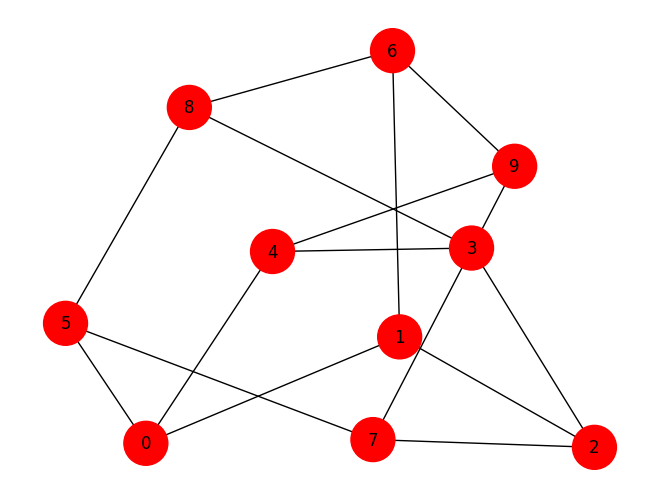

In [6]:
import networkx as nx

petersen = nx.petersen_graph()

nx.set_node_attributes(petersen,'red','color')

nx.draw(petersen, with_labels = True, node_color = [petersen.nodes[v]['color'] for v in petersen], node_size=1000)



A seguir apresenta-se uma nova versão da função que faz a coloração, para grafos do NetworX, alterando o valor do atributo cor, se for possível.

[1, -2, -3, -4, -5, -6, 7, -8, 9, -10, -11, -12, -13, -14, 15, -16, -17, 18, -19, -20, -21, -22, 23, -24, -25, 26, -27, -28, -29, 30, -31, -32, 33, -34, -35, -36, 37, -38, -39, -40]


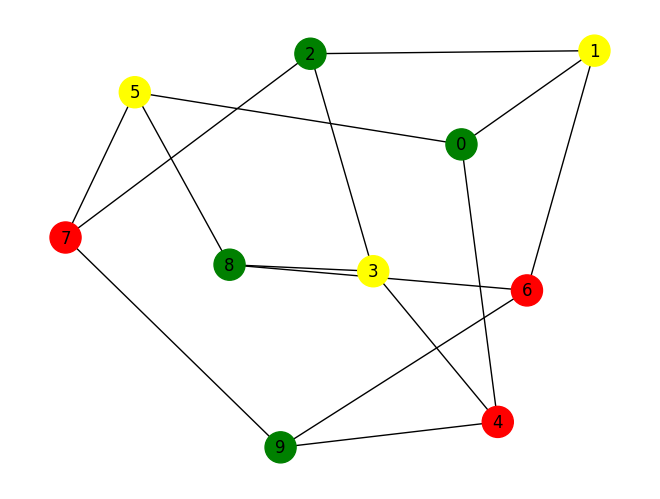

In [10]:
from pysat.solvers import Minisat22


def coloring(graph,V,colors):

    s = Minisat22()
    c = 1
    x = {}
    K = len(colors)

    for i in range(V):
        x[i] = {}
        for j in range(K):
            x[i][j] = c
            c += 1

    # # Para cada arco (u,v) as cores de u e v têm que ser diferentes.
    for j in range(K):
        for (u,v) in list(graph.edges):
            s.add_clause([-x[u][j], -x[v][j]])

    # Cada vértice tem pelo menos uma cor.
    for i in range(V):
        s.add_clause([x[i][j] for j in range(K)])

    # Cada vértice tem no máximo uma cor.
    for i in range(V):
        for a in range(K-1):
            for b in range(a+1,K):
                s.add_clause([-x[i][a] , -x[i][b]])


    if s.solve():
        m = s.get_model()
        print(m)

        for v in range(V):
            for k in range(K):
                if m[x[v][k]-1]>0:
                    # print("Vértice %s tem cor %s" % (v,k))
                    graph.nodes[v]['color'] = colors[k-1]
    else:
        print("Não é possivel colorir o grafo com %s cores." % (K))

    s.delete()

# Exemplo

coloring(petersen,petersen.number_of_nodes(),['red','yellow','blue','green'])

nx.draw(petersen, with_labels = True, node_color = [petersen.nodes[v]['color'] for v in petersen], node_size=500)
